In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
#import seaborn as sns; sns.set()
import pickle
import metpy
import glob
import pandas as pd
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import SkewT, Hodograph
from metpy.units import units
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

In [2]:
Sounding_dir = glob.glob('./datasets/Inglewood Soundings/*.txt')
Sounding_dir.sort()

In [3]:
def read_graw_txt(path):
    col_names = ['Time','pressure','temperature','rh','speed','direction','GeoPot','Lon','Lat']
    df = pd.read_csv(path,sep='\t',skiprows=1,names=col_names)
    return df
def plot_sonde_speed(df):
    delta_h = df['GeoPot'].diff()
    delta_t = df['Time'].diff()
    w = delta_t/delta_h
    print('average vertical velocity = {} m/s'.format(np.mean(w)))
    print('max vertical velocity = {} m/s'.format(np.max(w)))
    print('min vertical velocity = {} m/s'.format(np.min(w)))
    plt.plot(df['Time'],w)
    plt.xlabel('Time (s)')
    plt.ylabel('Vertical Velocity (m/s)')
    plt.show()

def qc_graw(df):
    df = df.dropna(subset=('temperature', 'rh', 'direction', 'speed'), how='all').reset_index(drop=True)
    if not df['GeoPot'].is_monotonic:
        print('Height is not monotonically increasing. Vertical velocity will be plotted then culprit rows '\
              'will be removed')
        plot_sonde_speed(df)
        mon_inc = (df[['GeoPot']].cummax().diff().fillna(.1) > 0).all(axis=1)
        new_df = df[mon_inc]
        print('Dropped {} rows that were not monotonically increasing'.format(len(df)-len(new_df)))
        df = new_df
    return df



Height is not monotonically increasing. Vertical velocity will be plotted then culprit rows will be removed
average vertical velocity = inf m/s
max vertical velocity = inf m/s
min vertical velocity = -5.0 m/s


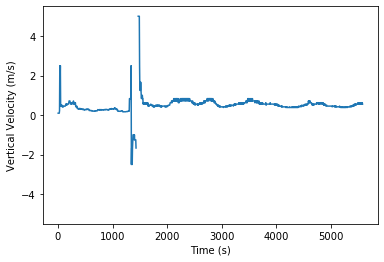

Dropped 43 rows that were not monotonically increasing


In [4]:
first_sounding = read_graw_txt(Sounding_dir[0])
first_sounding = qc_graw(first_sounding)

Height is not monotonically increasing. Vertical velocity will be plotted then culprit rows will be removed
average vertical velocity = inf m/s
max vertical velocity = inf m/s
min vertical velocity = -5.04990314285772e-06 m/s


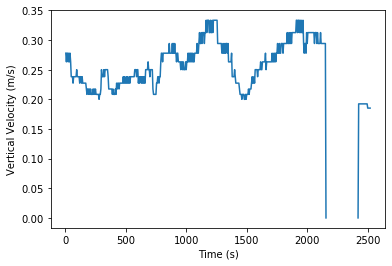

Dropped 73 rows that were not monotonically increasing


In [5]:
second_sounding = read_graw_txt(Sounding_dir[1])
second_sounding = qc_graw(second_sounding)

In [6]:
T.units

NameError: name 'T' is not defined

In [12]:

def basic_graw_sounding(df,skew=None,handles=None,hodo=False,barbs=True,sample_wind=10,ave_winds=False,print_thermo=True,T_style='r',Td_style='b-',linewidth=1.5,markercol='black',parcel_linestyle='c-',parcel_width=2,shadecape=False):
    if handles is None:
        handles = []
    p = df['pressure'].values * units.hPa
    T = df['temperature'].values * units.degC
    Td = mpcalc.dewpoint_rh(T, df['rh'].values/100)
    
    wind_speed = df['speed'].values * units.knots
    wind_dir = df['direction'].values * units.degrees
    u, v = mpcalc.wind_components(wind_speed, wind_dir)
    
    if skew is None:
        fig = plt.figure(figsize=(10,10))
        skew = SkewT(fig,rotation=45)

    handles.extend(skew.plot(p, T, T_style, linewidth=linewidth))
    handles.extend(skew.plot(p, Td, Td_style, linewidth=linewidth))
    
    if barbs:
        if sample_wind is not None:
            if ave_winds:
                u = pd.Series(u.magnitude).rolling(sample_wind, min_periods=1).mean().iloc[::sample_wind].values * u.units
                v = pd.Series(v.magnitude).rolling(sample_wind, min_periods=1).mean().iloc[::sample_wind].values * v.units
                p_wind = pd.Series(p.magnitude).rolling(sample_wind, min_periods=1).mean().iloc[::sample_wind].values * p.units
            else:
                u = pd.Series(u.magnitude).iloc[::sample_wind].values * u.units
                v = pd.Series(v.magnitude).iloc[::sample_wind].values * v.units
                p_wind = pd.Series(p.magnitude).iloc[::sample_wind].values * p.units
        else:
            p_wind = p
        skew.plot_barbs(p_wind, u, v)

    # Add the relevant special lines
    skew.plot_dry_adiabats()
    skew.plot_moist_adiabats()
    skew.plot_mixing_lines()
    skew.ax.axvline(0, color='g', linestyle='--', linewidth=1.5)
    skew.ax.axvline(-20, color='g', linestyle=':', linewidth=1.5)
    skew.ax.set_ylim(1000, 150)
    skew.ax.set_xlim(-20, 50)
    
    prof = mpcalc.parcel_profile(p, T[0], Td[0])
    
    if shadecape:
        skew.shade_cape(p, T, prof)
        
    #lcl_pressure, lcl_temperature = mpcalc.lcl(p[0], T[0], Td[0])
    #handles.extend(skew.plot(lcl_pressure, lcl_temperature, 'ko', markerfacecolor=markercol))
    #ax.annotate('SBLCL', (lcl_pressure, lcl_temperature))
    
    if print_thermo:
        print('LCL {}'.format(lcl_pressure))
        sbcape, sbcin = mpcalc.surface_based_cape_cin(p, T, Td)
        print('SBCAPE {}'.format(sbcape))
        print('SBCIN {}'.format(sbcin))
        
        P_parcel, t_parcel, td_parcel = mpcalc.mixed_parcel(p, T, Td, depth=300 * units.hPa)
        mlprof = mpcalc.parcel_profile(p, t_parcel, td_parcel)
        mlcape, mlcin = mpcalc.cape_cin(p, T, Td, mlprof)
        print('MLCAPE {}'.format(mlcape))
        print('MLCIN {}'.format(mlcin))
        
        MLLCLP, _ = mpcalc.lcl(P_parcel, t_parcel, td_parcel)
        print('ML Parcel: T = {}, Td = {}, LCL = {}'.format(t_parcel, td_parcel, MLLCLP))
        handles.extend(skew.plot(p, mlprof, parcel_linestyle, linewidth=parcel_width))
        #skew.shade_cape(p, T, mlprof)
    
    return handles, skew

In [8]:
first_sounding_end_time='05122016 1702'
first_launch_time = pd.to_datetime(first_sounding_end_time,format='%d%m%Y %H%M') - pd.Timedelta(seconds=first_sounding.Time.max())

second_sounding_end_time='05122016 1817'
second_launch_time = pd.to_datetime(second_sounding_end_time,format='%d%m%Y %H%M') - pd.Timedelta(seconds=second_sounding.Time.max())

In [9]:
legend_names = ['{} Temperature Trace'.format(first_launch_time.strftime('%Y-%m-%d %H:%M')),
                '{} Dewpoint Trace'.format(first_launch_time.strftime('%Y-%m-%d %H:%M')),
                '{} Surface Based LCL'.format(first_launch_time.strftime('%Y-%m-%d %H:%M')),
                '{} Mixed Layer Parcel'.format(first_launch_time.strftime('%Y-%m-%d %H:%M')),
                '{} Temperature Trace'.format(second_launch_time.strftime('%Y-%m-%d %H:%M')),
                '{} Dewpoint Trace'.format(second_launch_time.strftime('%Y-%m-%d %H:%M')),
                '{} Surface Based LCL'.format(second_launch_time.strftime('%Y-%m-%d %H:%M')),
                '{} Mixed Layer Parcel'.format(first_launch_time.strftime('%Y-%m-%d %H:%M'))]

LCL 690.629933682373 hectopascal
SBCAPE 2182.402634268913 joule / kilogram
SBCIN -47.934275177996575 joule / kilogram
MLCAPE 0.0012073217237414558 joule / kilogram
MLCIN 296.991478458876 joule / kilogram
ML Parcel: T = 39.8417201125817 degC, Td = 11.436697555148454 degC, LCL = 633.1323162139249 hectopascal


LCL 693.6738925418085 hectopascal
SBCAPE 817.8334800490394 joule / kilogram
SBCIN 2.748316651471898 joule / kilogram
MLCAPE 320.94702391388074 joule / kilogram
MLCIN 0.4493007236841026 joule / kilogram
ML Parcel: T = 37.00478912045219 degC, Td = 11.983316146537753 degC, LCL = 664.2642700877562 hectopascal


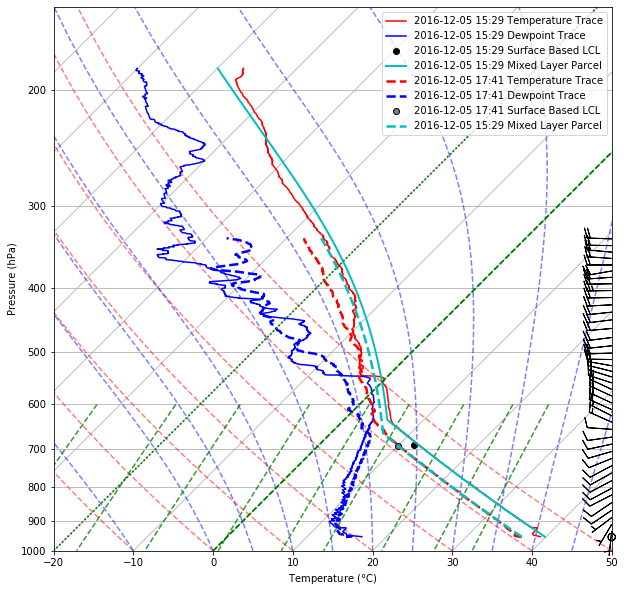

In [10]:
handles, skew = basic_graw_sounding(first_sounding,barbs=False,shadecape=False)
print('\n')
handles, skew = basic_graw_sounding(second_sounding,skew=skew,handles=handles,T_style='r--',Td_style='b--',linewidth=2.5,markercol='grey',parcel_linestyle='c--',parcel_width=2.5)
plt.legend(handles,legend_names,loc='upper right')
plt.xlabel('Temperature ($\degree$C)')
plt.ylabel('Pressure (hPa)')
plt.savefig('./soundings_5th.png',dpi=300)
plt.show()

array([-20., -10.,   0.,  10.,  20.,  30.,  40.,  50.,  60.]) <Unit('degC')>

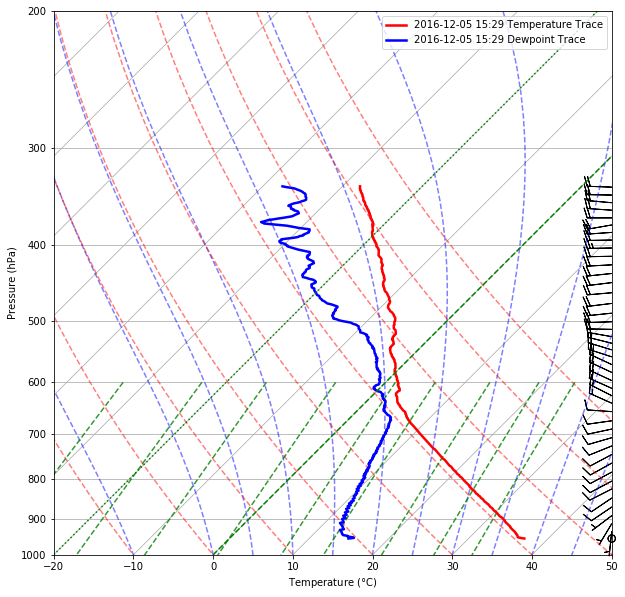

In [45]:
df = second_sounding
T_style = 'r-'
Td_style='b-'
linewidth=2.5
markercol='grey'

handles = []
p = df['pressure'].values * units.hPa
T = df['temperature'].values * units.degC
Td = mpcalc.dewpoint_rh(T, df['rh'].values/100)

wind_speed = df['speed'].values * units.knots
wind_dir = df['direction'].values * units.degrees
u, v = mpcalc.wind_components(wind_speed, wind_dir)

fig = plt.figure(figsize=(10,10))
skew = SkewT(fig,rotation=45)

handles.extend(skew.plot(p, T, T_style, linewidth=linewidth))
handles.extend(skew.plot(p, Td, Td_style, linewidth=linewidth))

barbs = True
sample_wind = 10 

if barbs:
    if sample_wind is not None:
            u = pd.Series(u.magnitude).iloc[::sample_wind].values * u.units
            v = pd.Series(v.magnitude).iloc[::sample_wind].values * v.units
            p_wind = pd.Series(p.magnitude).iloc[::sample_wind].values * p.units
    else:
        p_wind = p
    skew.plot_barbs(p_wind, u, v)

# Add the relevant special lines
#skew.plot_dry_adiabats()
skew.plot_moist_adiabats()
#skew.plot_mixing_lines()

skew.plot_dry_adiabats(t0=np.linspace(-20,70,10) * units.celsius)
skew.plot_mixing_lines()

skew.ax.axvline(0, color='g', linestyle='--', linewidth=1.5)
skew.ax.axvline(-20, color='g', linestyle=':', linewidth=1.5)
skew.ax.set_ylim(1000, 200)
skew.ax.set_xlim(-20, 50)

prof = mpcalc.parcel_profile(p, T[0], Td[0])
#handles, skew = basic_graw_sounding(second_sounding,T_style='r-',Td_style='b-',linewidth=2.5,markercol='grey',print_thermo=False)

plt.legend(handles,legend_names,loc='upper right')
plt.xlabel('Temperature ($\degree$C)')
plt.ylabel('Pressure (hPa)')
plt.savefig('./soundings_5th_KT.png',dpi=300)
plt.show()

In [15]:
help(skew)

Help on SkewT in module metpy.plots.skewt object:

class SkewT(builtins.object)
 |  SkewT(fig=None, rotation=30, subplot=None, rect=None, aspect=80.5)
 |  
 |  Make Skew-T log-P plots of data.
 |  
 |  This class simplifies the process of creating Skew-T log-P plots in
 |  using matplotlib. It handles requesting the appropriate skewed projection,
 |  and provides simplified wrappers to make it easy to plot data, add wind
 |  barbs, and add other lines to the plots (e.g. dry adiabats)
 |  
 |  Attributes
 |  ----------
 |  ax : `matplotlib.axes.Axes`
 |      The underlying Axes instance, which can be used for calling additional
 |      plot functions (e.g. `axvline`)
 |  
 |  Methods defined here:
 |  
 |  __init__(self, fig=None, rotation=30, subplot=None, rect=None, aspect=80.5)
 |      Create SkewT - logP plots.
 |      
 |      Parameters
 |      ----------
 |      fig : matplotlib.figure.Figure, optional
 |          Source figure to use for plotting. If none is given, a new
 |     

## Boundary layer cooling

In [21]:
first_sounding[first_sounding.pressure > 633.].temperature.mean() - second_sounding[second_sounding.pressure > 633.].temperature.mean()


3.7267952353942206

In [ ]:
def hodo(df):
    h = Hodograph(component_range=80.)
    h.add_grid(increment=20)
    h.plot_colormapped(u, v, wind_speed)

In [16]:
def find_first_pressure(df,value):
    return df.iloc[next(x for x, val in enumerate(df['pressure'].values) if val < value)]

In [17]:
find_first_pressure(first_sounding,633.)

Time           1075.00000
pressure        631.70000
temperature       5.80000
rh               85.00000
speed            11.00000
direction       272.00000
GeoPot         3563.00000
Lon             151.24621
Lat             -27.98795
Name: 215, dtype: float64

In [14]:
def find_first_temp(df,value):
    return df.iloc[next(x for x, val in enumerate(df.temperature) if val < value)]

print('Freeing level, first sounding:')
print(find_first_temp(first_sounding,0))
print('\n -20 level, first sounding:')
print(find_first_temp(first_sounding,-20))

print('\n Freeing level, second sounding:')
print(find_first_temp(second_sounding,0))
print('\n -20 level, second sounding:')
print(find_first_temp(second_sounding,-20))

Freeing level, first sounding:
Time           1290.00000
pressure        549.40000
temperature      -0.10000
rh               88.00000
speed            15.40000
direction       281.00000
GeoPot         4696.00000
Lon             151.26071
Lat             -27.98477
Name: 258, dtype: float64

 -20 level, first sounding:
Time           3215.00000
pressure        368.50000
temperature     -20.20000
rh               21.00000
speed            22.90000
direction       270.00000
GeoPot         7763.00000
Lon             151.42093
Lat             -27.97170
Name: 643, dtype: float64

 Freeing level, second sounding:
Time           1000.00000
pressure        582.70000
temperature      -0.10000
rh               87.00000
speed            18.70000
direction       295.00000
GeoPot         4195.00000
Lon             151.24471
Lat             -27.98628
Name: 200, dtype: float64

 -20 level, second sounding:
Time           1830.00000
pressure        388.50000
temperature     -20.10000
rh               4

## IR Ticks
The analysis of the Himawari-8 data requires translation of temperature into height using the data from this sounding. Generate the ticks that will be used in temperature, find the corresponding geopotential height and save the labels in a pickle file for that analysis.

In [ ]:
IR_ticks = np.linspace(20,-50,8)
IR_heights = [int(find_first_temp(first_sounding,x).GeoPot) for x in IR_ticks]
IR_labels = ['{} ({}m)'.format(int(T), height) for T, height in zip(IR_ticks, IR_heights)]
IR_tick_dict = {'IR_ticks':IR_ticks,'IR_labels':IR_labels}
pickle.dump(IR_tick_dict, open( "./datasets/IR_ticks.pickle", "wb" ))